# Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## 1.1 import libraries and import data (.json) for the login info.

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import statsmodels as sm


In [3]:
# read data from the local project folder
logins = pd.read_json('logins.json')
df = pd.DataFrame(logins)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Aggregate these login counts based on 15minute time intervals. To aggregate the data, the df shall be indexed by datetime (converted and combined) as 15-min interval.

In [4]:
df_login = df.resample('15min', on='login_time').count()

# cleaning df
df_login.index.name = "index"
df_login.reset_index(inplace=True)
df_login.rename({"login_time":"logins"}, axis=1, inplace=True)

# show
df_login.head()

,index,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


The day of the week and login hour in each day shall be known for further analysis

In [5]:
from datetime import datetime as dt
df_login['day'] = df_login['index'].dt.day_name()
df_login['hour'] = df_login['index'].dt.hour
df_login.head()

,index,logins,day,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [6]:
# extract morning, afternoon
df_login["AM-PM"] = df_login["hour"].apply(lambda x: "PM" if x in range(11,23) else "AM")
df_login.head()

,index,logins,day,hour,AM-PM
0,1970-01-01 20:00:00,2,Thursday,20,PM
1,1970-01-01 20:15:00,6,Thursday,20,PM
2,1970-01-01 20:30:00,9,Thursday,20,PM
3,1970-01-01 20:45:00,7,Thursday,20,PM
4,1970-01-01 21:00:00,1,Thursday,21,PM


In [7]:
df_daily = df_login.groupby('day')[['logins']].sum().sort_values(by='logins', ascending=False)
df_daily

,logins
day,
Saturday,19377
Sunday,18167
Friday,15208
Thursday,11960
Wednesday,10339
Tuesday,9268
Monday,8823


It makes sense that Saturday and Sunday have more logins than weekdays. Now we extract more to compare the daily logins by AM and PM. The groupby method is grouped by day and AM-PM and the average logins in the periods were calculated.

In [8]:
df_ampm = df_login.groupby(['day','AM-PM'])[['logins']].sum().sort_values(by='day',ascending=False)
df_ampm['daily_avg'] = df_login.groupby(['day','AM-PM'])[['logins']].mean().sort_values(by='day',ascending=False)
df_ampm

logins  daily_avg
day       AM-PM                   
Wednesday AM       4421   6.578869
          PM       5918   8.806548
Tuesday   AM       3670   5.461310
          PM       5598   8.330357
Thursday  AM       5089   7.528107
          PM       6871  10.045322
Sunday    AM      10616  14.744444
          PM       7551  10.487500
Saturday  AM      10851  15.070833
          PM       8526  11.841667
Monday    AM       3490   4.874302
          PM       5333   7.575284
Friday    AM       6203   8.615278
          PM       9005  12.506944

## 1.2 EDA

Let us try to plot some average daily logins over the entire course of the week

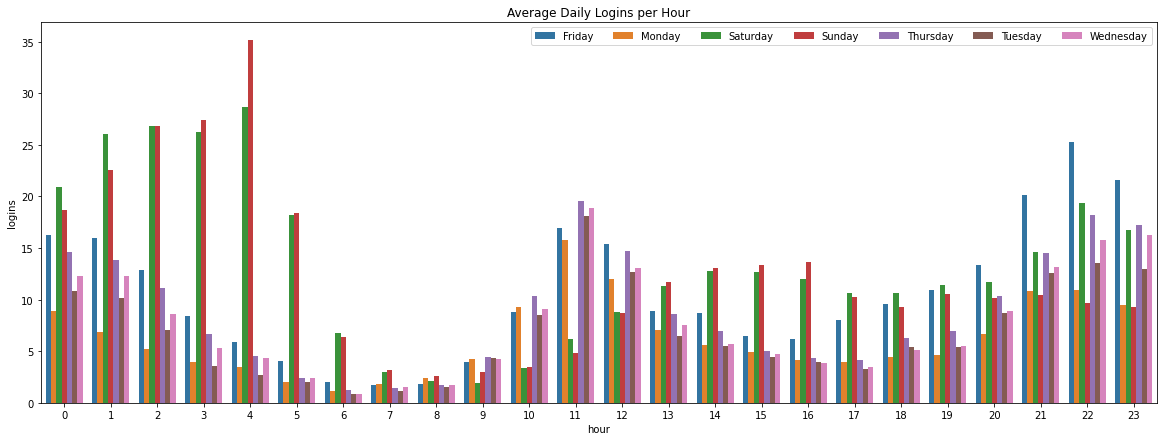

In [9]:
#getting average daily logins per hour
df_total = df_login.groupby(["hour", "day"]).mean().reset_index()

#plotting df
fig, axes = plt.subplots(figsize=(20,7))
ax = sns.barplot(x="hour", y="logins", data=df_total, hue="day")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour")
plt.xticks(range(0,24))

#display plot
plt.show()

The login counts were plotted on a monthly level to the peak demond month in the dataset.

Text(0, 0.5, 'Total number of login counts')

<Figure size 1296x432 with 0 Axes>

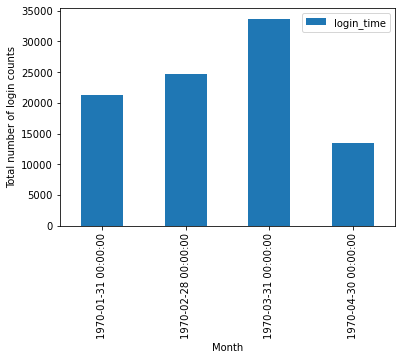

In [10]:
df = df.set_index(pd.to_datetime(df['login_time']))
df_sampled = df.resample('M').count()
plt.figure(figsize=(18,6))
df_sampled.plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('Total number of login counts')

The trend of the login counts in each day

C:\Users\weiru\AppData\Local\Temp\ipykernel_14724\1249319714.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=df_daily["index"].dt.day, rotation=60, ha='right')


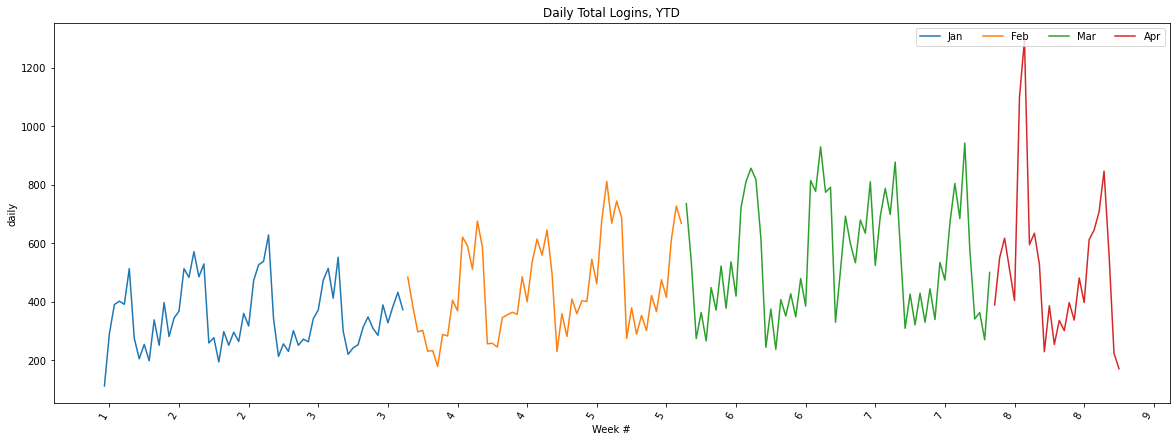

In [11]:
import matplotlib.dates as mdates
# resampling df to daily invervals
df_daily = df.resample("12H", on="login_time").count()

# cleaning df
df_daily.index.name = "index"
df_daily.reset_index(inplace=True)
df_daily.rename({"login_time":"daily"}, axis=1, inplace=True)

# extracting months
df_daily["month"] = df_daily["index"].dt.month
df_daily["month"] = df_daily["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr"})

# plotting df_daily
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="index", y="daily", data=df_daily, hue="month")
ax.legend(loc="upper right", ncol=5)
ax.set(title="Daily Total Logins, YTD", xlabel="Week #")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_xticklabels(labels=df_daily["index"].dt.day, rotation=60, ha='right')

# display df_daily
plt.show()

In April, there is a huge spike in number of login counts, which means that it is a peak time in that month. Also, the logins are gradually increasing on a daily basis.

# Part 2: Experiment and Metrics

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Solution: 

The key measure of success of this experiment is the average waiting time between the two continuous trips during the weekdays and weekends. This will measure how busy the drivers are and how they will be paid off for their hard work. 

The Ultimate will provide timely taxi demands information to drivers and give recommendations which cities they shall drive for taxi services at that specific time slots. For trips between different cities or taxi demands in the other city, Ultimate shall consider the bridege tolls when they give the recommendations to drivers. Finally, the average waiting time of each driver will be provided to inform them how much more money they earned during the experiment. That extra profit will persuade drivers to shift their drives based on taxi demands to cover the bridge tolls after this experiment.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Solution: 

a. 
Firstly, I would track/keep an eye on all of the drivers movements like where/which city they might be located in. This can be in weekdays or weekends. The next step I will take would be to let all the drivers know about this new toll policy on how it got changed. Once informed, I would then try to track their rides and movements on where the drivers are, i.e, in which cities they now tend to be in. A prominient thing we can discover is how many times the drivers keep travelling in between the cities and how many times the location changes. 

b. There are a few statistical tests which come in handy to use for this type of problem. The one I would use is a paired t-test. Basically, t-test is useful in calculating the means. 

c. Here I can use a paired t-test for comparing the mean trips of the drivers before and after the experiment. Number of trips also should be take into account just to see how significact the changes are. If the effect size level of the t-test is > 0.2 as Cohen suggested, then there is a difference in change of the method/experiment proposed, which is considerable. Then the experiment can be employed for the future as well, if there is good amount of expenses/investment coming in.

# Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Those will be answered in the conclusions.

## 3.1 EDA

Let us now open the file needed for predictive modelling. Let's do some analysis first before proceeding to the ML part.

In [12]:
#load data and visualize
import json

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


As mentioned in the project question, the users need to be labeled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. There are two variables missing values (avg_rating_of_driver with 41878 observations and avg_rating_by_driver with 49799 observations). It seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the mean value so as to not affect the current distribution, which is primarily high ratings.

In [15]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

As mentioned in the project questions, the criterion of judging inactive and active users is if the users are active in the sixth month from January to June. Converting the signup date and last trip date to datetime objects then encode each user active in June as True, otherwise will be False.

In [16]:
# set as datatime objects
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [17]:
# encode target variable 'active' as true or false for last trip in June
df['active'] = [1 if x.month >=6 else 0 for x in df.last_trip_date]

# encode ultimate_black_user as categorical
df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]

In [18]:
df = df.drop(['last_trip_date', 'signup_date'], axis =1)

plot the hist plot to check the ratio of active users to inactive users

Percent of Active Users: 0.37608


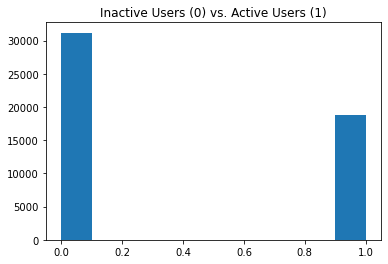

In [19]:
plt.hist(df.active)
plt.title('Inactive Users (0) vs. Active Users (1)')
plt.show
print('Percent of Active Users: {}'.format(sum(df.active)/len(df.active)))

The classification is imbalanced, but not tremendously. This should not present too much of a problem while modeling.

## 3.2 Feature Engineering

Based on the size, variables, and relationship b/w those variables, an appropriate model can be selected to describe this data set. A pairplot can help summarize the variables relationships between each other.

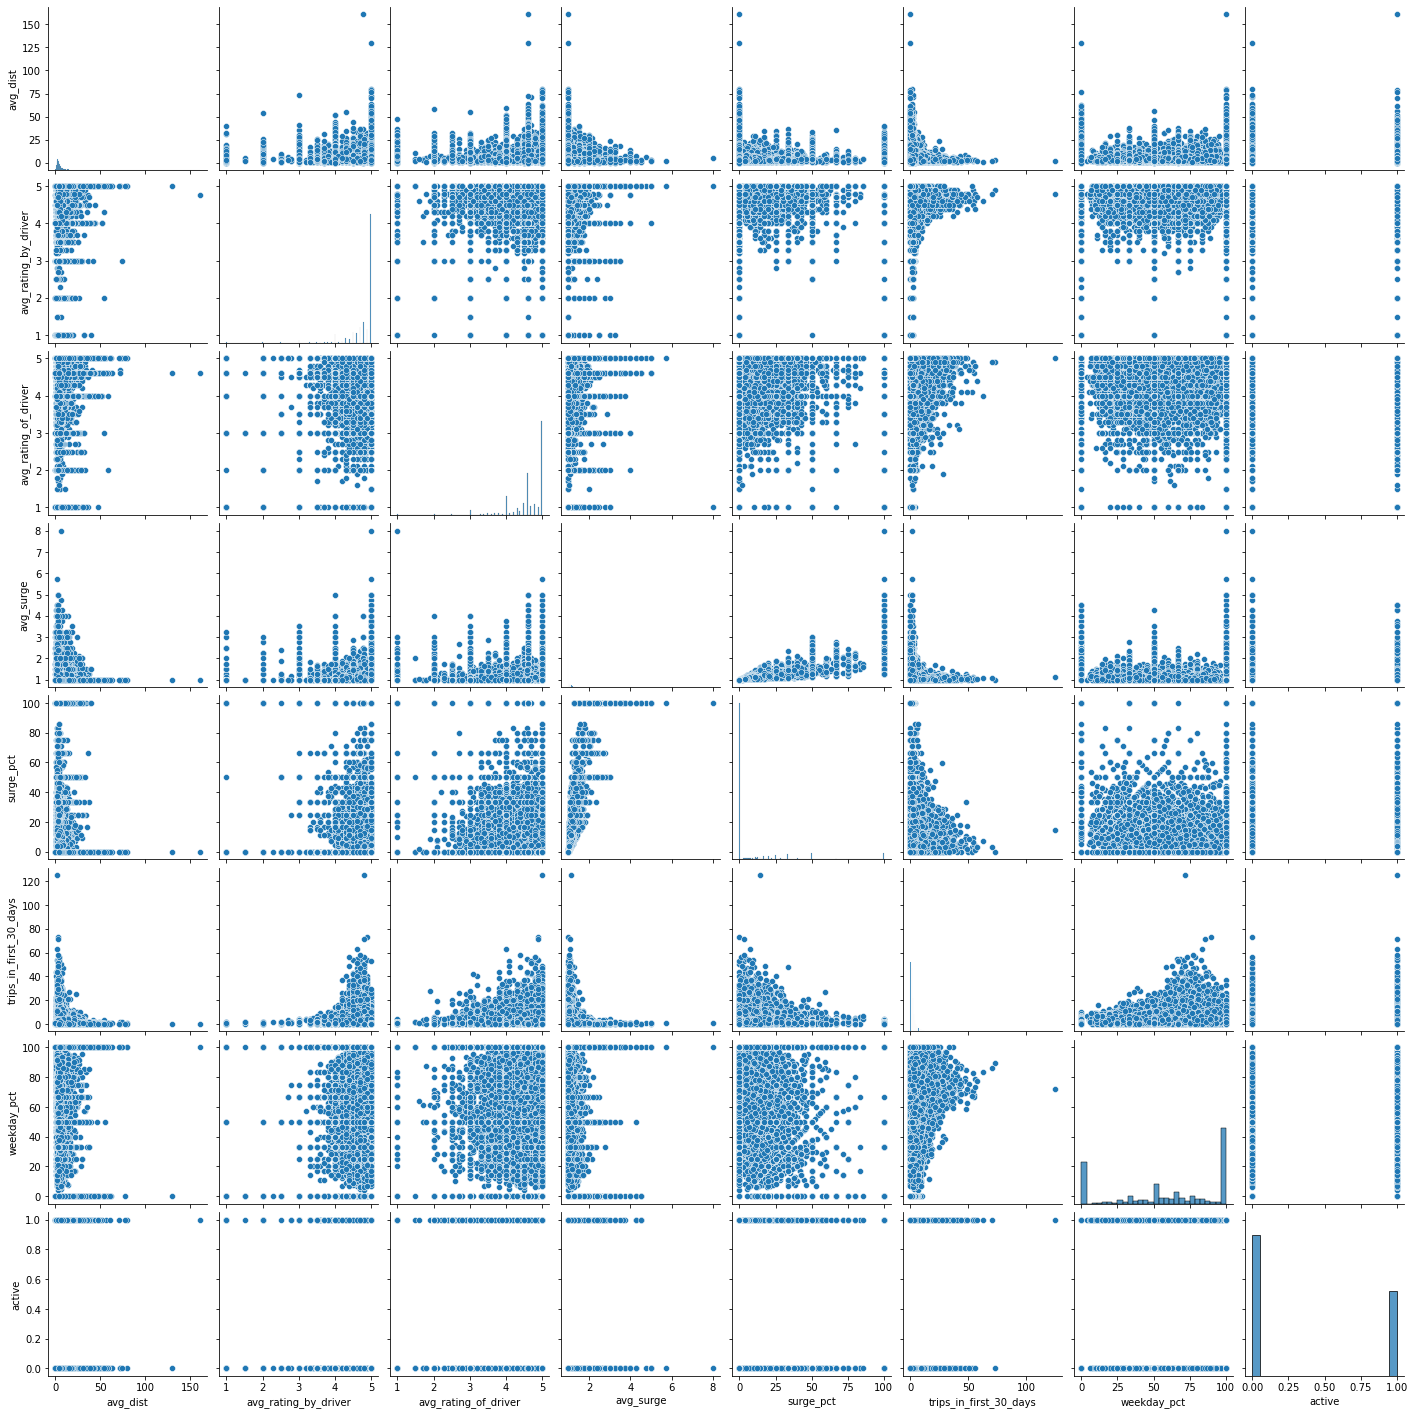

In [20]:
#select out only continuous variables
df_pp = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
           'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'active']]

sns.pairplot(df_pp)

Encoding discrete variables

In [21]:
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


## 3.3 Predictive Modeling

First, splitting the train and test datasets and normalize both separately.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# separate data and labels
X = df.drop('active', axis=1)
y = df.active

# split 0.3 for test and 0.7 for train
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# normalize both datasets after splitting
X_train = normalize(X_train)
y_train = normalize(y_train)

Second, the KNN model is used as the base model of this classification problem.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Let's try the out of the box classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, X_test)

# test the accuracy first
knn.score(y_train, y_test)

0.7472

Third, cross-validate the model and tune its parameters

In [24]:
from sklearn.model_selection import GridSearchCV

# specify a parameter grid to search over
parameters = {
    'n_neighbors': [10, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_cv = GridSearchCV(knn, parameters, cv=5) #specify GridSearchCV object
knn_cv.fit(X_train, X_test) # fit to training data

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [10, 13, 15],
                         'weights': ['uniform', 'distance']})

In [25]:
# find the best parameters of the classifiers
knn_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

It shows that the manhattan distance with 13 neighbors and uniform weighting are the best option.

In [26]:
# check for accuracy improvement (comparing with the base case)
knn_cv.score(y_train, y_test)

0.759

The cross validation improved about 1.2% out of the test data.

## 3.4 Model Performance

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# predict classification
y_pred = knn_cv.predict(y_train)

print(classification_report(y_test, y_pred)) # print classification report

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      9379
           1       0.71      0.61      0.66      5621

    accuracy                           0.76     15000
   macro avg       0.75      0.73      0.74     15000
weighted avg       0.76      0.76      0.76     15000

Confusion Matrix:
[[7942 1437]
 [2178 3443]]


Based on the matrix above, it is clear that the model is much better at predicting a user who will go inactive over a user who will remain active in their sixth month. This is likely due to the class support and less likely due to the intrinsic value of the data. The reason is because the percision of the 'active' predictions is fairly high, but recall is suffering because the model is failing to notice preditive features of the 'active' class. For a better idea of the overall performace of the model, refer to the ROC curve below.

C:\Users\weiru\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


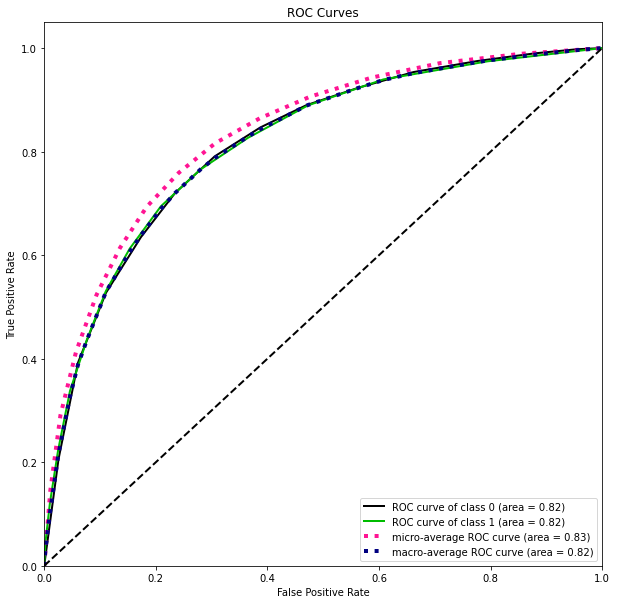

AUC score: 0.7296549167071625


In [29]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

# plot roc curve and print AUV score
y_probas = knn_cv.predict_proba(y_train)
skplt.metrics.plot_roc_curve(y_test, y_probas, figsize=(10,10))
plt.show()
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))

What this curve visualizes, and the AUC score (0.730) indicates, is that this model is about 75% positive rate to predict whether users will be active in the 6th month. The f1-score for predicting an active user was merely 66% which is only 16% higher than random guessing.

## 3.4 Feature Importance

By using cross-validation and testing each feature individually, each individual feature can be observed for its effect on the model performance.

In [35]:
from sklearn.model_selection import cross_val_score

#instate a new classifier 
#to be used as index for feature number
n_feats = df.shape[1]

#loop over each feature, cross validate and print score
print('Feature  Accuracy')
for i in range(n_feats):
    X = df.iloc[:, i].values.reshape(-1, 1)
    knn_feat_test = KNeighborsClassifier(n_neighbors=13, weights='uniform', metric='manhattan')
    scores = cross_val_score(knn_feat_test, X, y)
    print('%d        %g' % (i, scores.mean()))

Feature  Accuracy
0        0.62906
1        0.68
2        0.69426
3        0.7136
4        0.62644
5        0.72618
6        0.59656
7        0.69358
8        1
9        0.62392
10        0.66482
11        0.62392
12        0.62392
13        0.56694


So thanks to cross-validation it is apparent that the main features of this data set (in terms of the target variable) are feature 2, 3, 5, and 7 (avg_surge, surge_pct, weekday_pct, and avg_rating_by_driver). Looking at these variables in terms of the target variable might reveal details about users who remain active.

Text(0.5, 1.0, 'weekday_pct for users active @ 6 months')

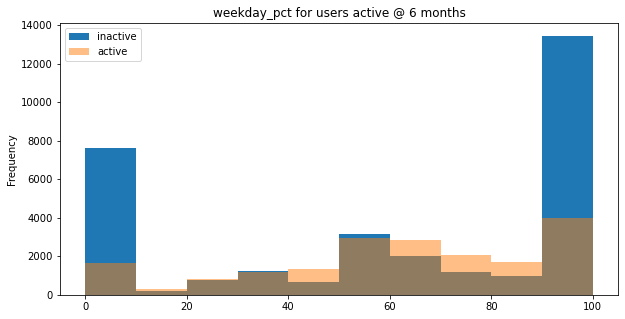

In [36]:
#subset active and inactive users for feature 5
feat_5_active = df.weekday_pct.loc[df['active'] == 1]
feat_5_inactive = df.weekday_pct.loc[df['active'] == 0]

plt.figure(figsize=(10,5))

#plot
feat_5_inactive.plot(kind='hist')
feat_5_active.plot(kind='hist', alpha=0.5)
plt.legend(['inactive', 'active'])
plt.title('weekday_pct for users active @ 6 months' )

From the chart above, there are users who ride exclusively during the weekdays or during the weekends, but a mix of both was a better marker for users who will be active within 6 months. Since the model recognized users who became inactive within 6 months, it is likely that being an exclusive weekender or exclusive weekdayer is a strong marker of potential user loss.

Text(0.5, 1.0, 'surge_pct for users active @ 6 months')

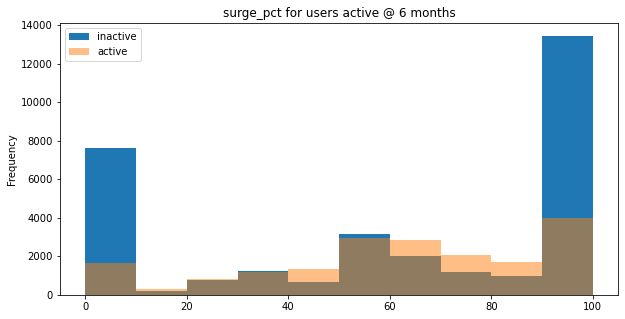

In [37]:
#subset active and inactive users for feature 3
feat_3_active = df.weekday_pct.loc[df['active'] == 1]
feat_3_inactive = df.weekday_pct.loc[df['active'] == 0]

plt.figure(figsize=(10,5))

#plot
feat_3_inactive.plot(kind='hist')
feat_3_active.plot(kind='hist', alpha=0.5)
plt.legend(['inactive', 'active'])
plt.title('surge_pct for users active @ 6 months' )

From the chart above, the surge percent has the similar trend with the weekday percent.

## 3.5 Conclusions

1. After filling in the missing values with average values of the ratings by drivers and of drivers, We know the retaintion rate of the active users (lating 6 months) was 37.6%. It was about 66% of trips occured during weekdays. The average surge multiplier of trips is 1.07 with standard deviation 0.22. This showed that trips were evenly distributed at the mean values for most of users. The median distance of trips was 3.88 miles and the average distance was 5.8 miles. Most of trips were short or medium distances, which were possibly within the city.

2. I used K-Nearest Neighbors (KNN) model to predict the inactive/active users. KNN is one of the most basic yet essential classification algorithms in Machine Learning. It belongs to the supervised learning domain and finds intense application in pattern recognition, data mining and intrusion detection. The alternative models include Random Forest, Gradient Boost, SVM, and Naive Bayes. I used f1-score (0.66) and accuracy (0.759) to evaluate the model performance. The ROC curve and AUC score (0.73) were further used. 

3. From the feature importance analysis, the weekday percent and the surge percent are the largest two impactors on rider retention. A survey will be recommended to those inactive riders with high and low ends of weekday percent and surge percent. Through the survey, we shall know the reasons why they were not active users.